**Spectral Calibration Of Ocean Optics Spectrometer**  
**Author: Ramesh Bhatta,CIS, RIT**  
**Data: Dr. Anthony Vodacek, CIS, RIT**

In [3]:
## Import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [4]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

**1. Reading the Data**

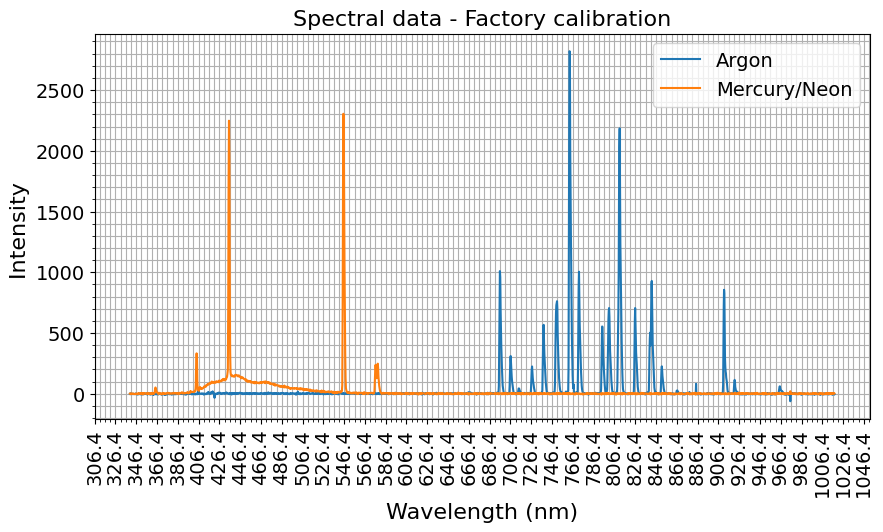

In [6]:


## Import the spectral data

Ar_spectrum = pd.read_csv('Ar_Subt2_17-03-13-713.txt', sep='\t', skiprows=13, header=None)
Hg_spectrum = pd.read_csv('Hg_Subt2_17-10-06-072.txt', sep='\t', skiprows=13, header=None)

Ar_spectrum_copy = Ar_spectrum.copy()
Hg_spectrum_copy = Hg_spectrum.copy()

## Plot wavelength vs intensity

fig=plt.figure(figsize=(10, 5))
plt.plot(Ar_spectrum_copy[0], Ar_spectrum_copy[1], label='Argon')
plt.plot(Hg_spectrum_copy[0], Hg_spectrum_copy[1], label='Mercury/Neon')
# Set xticks at a detailed scale
start, end = plt.xlim()
xticks = np.arange(start, end, step=20)
plt.xticks(xticks, rotation='vertical')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity ')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Spectral data - Factory calibration')
plt.show()


**2. Removing the factory calibrated wavelength and generating a Pixels Vs Intensity Plot**

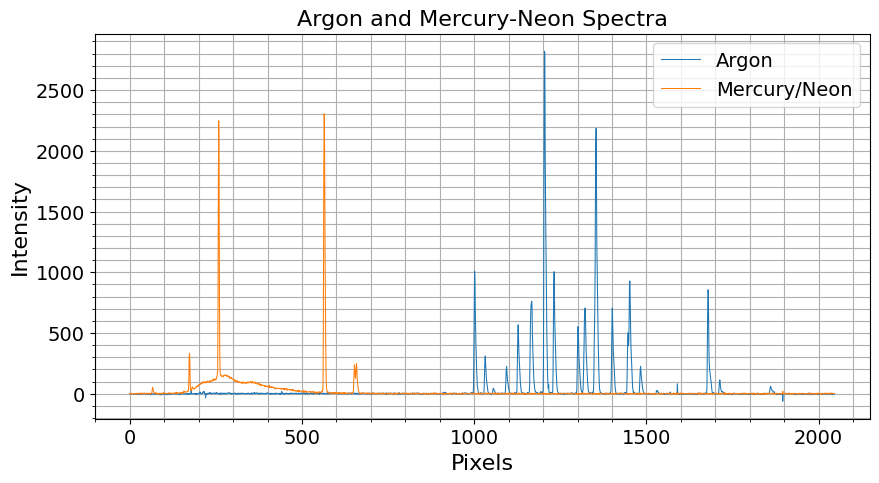

In [7]:
## Remove the wavelength cloumn and replace it by pixels in increasing order---> Pixel Vs Intensity Plot

Ar_spectrum = Ar_spectrum.drop(columns=0)
Ar_spectrum = Ar_spectrum.reset_index(drop=True)
Ar_spectrum = Ar_spectrum.rename(columns={1: 'Intensity'})
Ar_spectrum['Pixels'] = Ar_spectrum.index

Hg_spectrum = Hg_spectrum.drop(columns=0)
Hg_spectrum = Hg_spectrum.reset_index(drop=True)
Hg_spectrum = Hg_spectrum.rename(columns={1: 'Intensity'})
Hg_spectrum['Pixels'] = Hg_spectrum.index

## Plot the Argon and Mercury spectra as a function of pixels

fig = plt.figure(figsize=(10, 5))
plt.plot(Ar_spectrum['Pixels'], Ar_spectrum['Intensity'], label='Argon', linewidth=0.75)
plt.plot(Hg_spectrum['Pixels'], Hg_spectrum['Intensity'], label='Mercury/Neon', linewidth=0.75)
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.grid(which='both')
plt.minorticks_on()
plt.title('Argon and Mercury-Neon Spectra')
plt.legend()
plt.show()


**3. Gaussian fitting the lines to find pixels at which peak occurs**

In [8]:
## Find  the  pixels at which the peaks occur for both the Argon and Mercury spectra by fitting a Gaussian to the peaks and getting the mean of the Gaussian

def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fit_gaussians(data, threshold):
    peaks, _ = find_peaks(data['Intensity'], height=threshold)
    centers = []
    intensities = []
    for peak in peaks:
        try:
            popt, _ = curve_fit(gaussian, data['Pixels'], data['Intensity'], p0=[data['Intensity'][peak], data['Pixels'][peak], 1])
            centers.append(int(popt[1]))
            intensities.append(data['Intensity'][peak])
        except RuntimeError:
            print("Error - curve_fit failed")
    return pd.DataFrame({'Pixels': centers, 'Peak Intensity': intensities})

Ar_table = fit_gaussians(Ar_spectrum, threshold=850)
Hg_table = fit_gaussians(Hg_spectrum, threshold=200)

**4. Selecting Only those lines which are higher than certain threshold values**

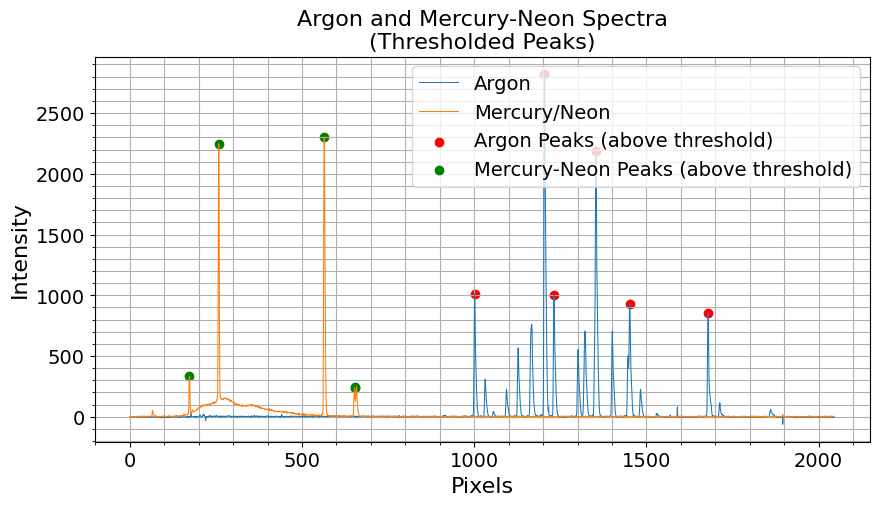

In [10]:
## Show the thresholded peaks with vertical lines at the peak positions

fig = plt.figure(figsize=(10, 5))
plt.plot(Ar_spectrum['Pixels'], Ar_spectrum['Intensity'], label='Argon', linewidth=0.75)
plt.plot(Hg_spectrum['Pixels'], Hg_spectrum['Intensity'], label='Mercury/Neon', linewidth=0.75)
plt.scatter(Ar_table['Pixels'], Ar_table['Peak Intensity'], color='red', label='Argon Peaks (above threshold)')
plt.scatter(Hg_table['Pixels'], Hg_table['Peak Intensity'], color='green', label='Mercury-Neon Peaks (above threshold)')
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.grid(which='both')
plt.minorticks_on()
plt.title('Argon and Mercury-Neon Spectra\n(Thresholded Peaks)')
plt.legend()
plt.show()

**5. Making a table of Pixels Vs Intensity Values**

In [11]:
## Combine the two tables

Hg_table['Element'] = 'Mercury-Neon'
Ar_table['Element'] = 'Argon'
table = pd.concat([Ar_table, Hg_table])


## Sort the table by the pixel number

table = table.sort_values(by='Pixels')

## Remove duplicate pixels in the table

table = table.drop_duplicates(subset='Pixels', keep='first')
table

,Pixels,Peak Intensity,Element
0,173,332.94,Mercury-Neon
1,258,2247.94,Mercury-Neon
2,564,2304.94,Mercury-Neon
3,655,237.94,Mercury-Neon
0,1001,1009.83,Argon
1,1204,2819.83,Argon
2,1232,1004.83,Argon
3,1353,2184.83,Argon
4,1451,928.83,Argon
5,1679,855.83,Argon


**6. Collecting the true wavelength of the spectral lines selected above from Spectral Lines lamp user manual and adding them to the table corresponding to their pixel numbers.
Also Calculating higher power of pixel numbers for polynomial fitting and adding them to the table too.**

In [12]:
## Add true wavelengths corresponding to the spectral lines of Ar and Hg to the table

table['True_wavelength'] = [ 404.66, 435.84, 546.07, 576.96, 696.54, 763.51, 772.38, 811.53, 842.46, 912.3]

## Drop peak intensity column and element column from the table

table = table.drop(columns=['Peak Intensity', 'Element'])

## swap the columns in the table

table = table[['True_wavelength', 'Pixels']]

## Append pixel squared and pixel cubed columns to the table

table['Pixels^2'] = table['Pixels']**2
table['Pixels^3'] = table['Pixels']**3
table['Pixels^4'] = table['Pixels']**4
table['Pixels^5'] = table['Pixels']**5

**7. Linear Fitting the pixel to wavelength and showing the slope and intercept coefficients**

In [13]:
## Linear fit the pixels to the true wavelengths

def linear_fit(x, m, c):
    return m*x + c

popt, _ = curve_fit(linear_fit, table['Pixels'], table['True_wavelength'])
slope, intercept = popt

## Predict the true wavelengths from the pixel values using linear fit
print(f'\nLinear fit coefficients: slope= {slope} and intercept= {intercept}')
table['linear_predicted_wavelength'] = linear_fit(table['Pixels'], slope, intercept)

## calculate the residuals and append them to the table

table['linear_residuals'] = table['True_wavelength'] - table['linear_predicted_wavelength']


Linear fit coefficients: slope= 0.339102960950505 and intercept= 351.70346636310114


**8. Regression Statistics for the Linear Fit**

In [14]:
## Regression statistics

def regression_stats(data, y, y_pred):
    residuals = data[y] - data[y_pred]
    SS_res = np.sum(residuals**2)
    SS_tot = np.sum((data[y] - np.mean(data[y]))**2)
    R2 = 1 - SS_res/SS_tot
    
    ## rmse
    rmse = np.sqrt(SS_res/len(data))
    
    return R2, rmse

R2_linear, rmse_linear = regression_stats(table, 'True_wavelength', 'linear_predicted_wavelength')
print(f'R^2 value for linear fit: {R2_linear}\nRMSE: {rmse_linear}')

R^2 value for linear fit: 0.9993049352415168
RMSE: 4.390046489918326


**9. Performing a 3rd degree polynomial Fitting and showing the statistics of the fit**

In [15]:
## Perform a 3rd degree polynomial fit

def poly_fit(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

popt, _ = curve_fit(poly_fit, table['Pixels'], table['True_wavelength'])
a, b, c, d = popt

## Predict the true wavelengths from the pixel values using 3rd degree polynomial fit
print(f'\n3rd degree polynomial fit coefficients: a= {a}, b= {b}, c= {c} and d= {d}')

table['poly_predicted_wavelength'] = poly_fit(table['Pixels'], a, b, c, d)

## calculate the residuals and append them to the table

table['poly_residuals'] = table['True_wavelength'] - table['poly_predicted_wavelength']

## Regression statistics

R2_poly, rmse_poly = regression_stats(table, 'True_wavelength', 'poly_predicted_wavelength')
print(f'R^2 value for 3rd degree polynomial fit: {R2_poly}\nRMSE: {rmse_poly}')


3rd degree polynomial fit coefficients: a= -3.466324119254407e-09, b= -1.237482944949514e-05, c= 0.37083663008188167 and d= 340.97602880593945
R^2 value for 3rd degree polynomial fit: 0.9999972542301794
RMSE: 0.2759234098542776


**10. Performing a 4th degree polynomial Fitting and showing the statistics of the fit**

In [16]:
## perform a 4th order polynomial fit

def poly_fit(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

popt, _ = curve_fit(poly_fit, table['Pixels'], table['True_wavelength'])
e, f, g, h, i = popt

## Predict the true wavelengths from the pixel values using 4th degree polynomial fit
print(f'\n4th degree polynomial fit coefficients: a= {e}, b= {f}, c= {g}, d= {h} and e= {i}')

table['poly4_predicted_wavelength'] = poly_fit(table['Pixels'], e,f,g,h,i)

## calculate the residuals and append them to the table

table['poly4_residuals'] = table['True_wavelength'] - table['poly4_predicted_wavelength']

## Regression statistics

R2_poly4, rmse_poly4 = regression_stats(table, 'True_wavelength', 'poly4_predicted_wavelength')
print(f'R^2 value for 4th degree polynomial fit: {R2_poly4}\nRMSE: {rmse_poly4}')


4th degree polynomial fit coefficients: a= -1.461737820014975e-12, b= 2.0232316403092354e-09, c= -1.9220567185831687e-05, d= 0.3739979529649978 and e= 340.56720986108013
R^2 value for 4th degree polynomial fit: 0.9999973055933481
RMSE: 0.2733304747914264


**11. Performing a 5th degree polynomial Fitting and showing the statistics of the fit**

In [17]:
## Perform a 5th degree polynomial fit

def poly_fit(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

popt, _ = curve_fit(poly_fit, table['Pixels'], table['True_wavelength'])
j,k,l,m,n,o = popt

## Predict the true wavelengths from the pixel values using 5th degree polynomial fit
print(f'\n5th degree polynomial fit coefficients: a= {j}, b= {k}, c= {l}, d= {m}, e= {n} and f= {o}')

table['poly5_predicted_wavelength'] = poly_fit(table['Pixels'],j,k,l,m,n,o)

## calculate the residuals and append them to the table

table['poly5_residuals'] = table['True_wavelength'] - table['poly5_predicted_wavelength']

## Regression statistics

R2_poly5, rmse_poly5 = regression_stats(table, 'True_wavelength', 'poly5_predicted_wavelength')
print(f'R^2 value for 5th degree polynomial fit: {R2_poly5}\nRMSE: {rmse_poly5}')


5th degree polynomial fit coefficients: a= 6.6461857172239196e-15, b= -3.2940888472814765e-11, c= 5.7044961114211616e-08, d= -6.24800975453517e-05, e= 0.38866214463658744 and f= 338.9810716259873
R^2 value for 5th degree polynomial fit: 0.9999974665330379
RMSE: 0.26504163828141974


**12. Final Table with all the predictions and Residuals  
(Note: This table is also upload as excel sheet along with this file)**

In [18]:
## Final Results Table
print('\nFinal Results Table:')
table.to_excel("final_results_table.xlsx", index=False)
table


Final Results Table:


,True_wavelength,Pixels,Pixels^2,Pixels^3,Pixels^4,Pixels^5,linear_predicted_wavelength,linear_residuals,poly_predicted_wavelength,poly_residuals,poly4_predicted_wavelength,poly4_residuals,poly5_predicted_wavelength,poly5_residuals
0,404.66,173,29929,5177717,895745041,154963892093,410.368279,-5.708279,404.742452,-0.082452,404.702770,-0.042770,404.616542,0.043458
1,435.84,258,66564,17173512,4430766096,1143137652768,439.192030,-3.352030,435.768632,0.071368,435.807553,0.032447,435.938286,-0.098286
2,546.07,564,318096,179406144,101185065216,57068376781824,542.957536,3.112464,545.569625,0.500375,545.603144,0.466856,545.592230,0.477770
3,576.96,655,429025,281011375,184062450625,120560905159375,573.815906,3.144094,577.590834,-0.630834,577.589265,-0.629265,577.517625,-0.557625
0,696.54,1001,1002001,1003003001,1004006004001,1005010010005001,691.145530,5.394470,696.307171,0.232829,696.241847,0.298153,696.249659,0.290341
1,763.51,1204,1449616,1745337664,2101386547456,2530069403137024,759.983431,3.526569,763.474675,0.035325,763.457850,0.052150,763.514635,-0.004635
2,772.38,1232,1517824,1869959168,2303789694976,2838268904210432,769.478314,2.901686,772.582059,-0.202059,772.575074,-0.195074,772.625573,-0.245573
3,811.53,1353,1830609,2476813977,3351129310881,4534077957621993,810.509773,1.020227,811.479075,0.050925,811.513793,0.016207,811.499229,0.030771
4,842.46,1451,2105401,3054936851,4432713370801,6431867101032251,843.741863,-1.281863,842.416599,0.043401,842.472618,-0.012618,842.382804,0.077196
5,912.30,1679,2819041,4733169839,7946992159681,13342999836104399,921.057338,-8.757338,912.318878,-0.018878,912.286086,0.013914,912.313418,-0.013418


**13. Plotting the data to show the accuracy of fit for each model**

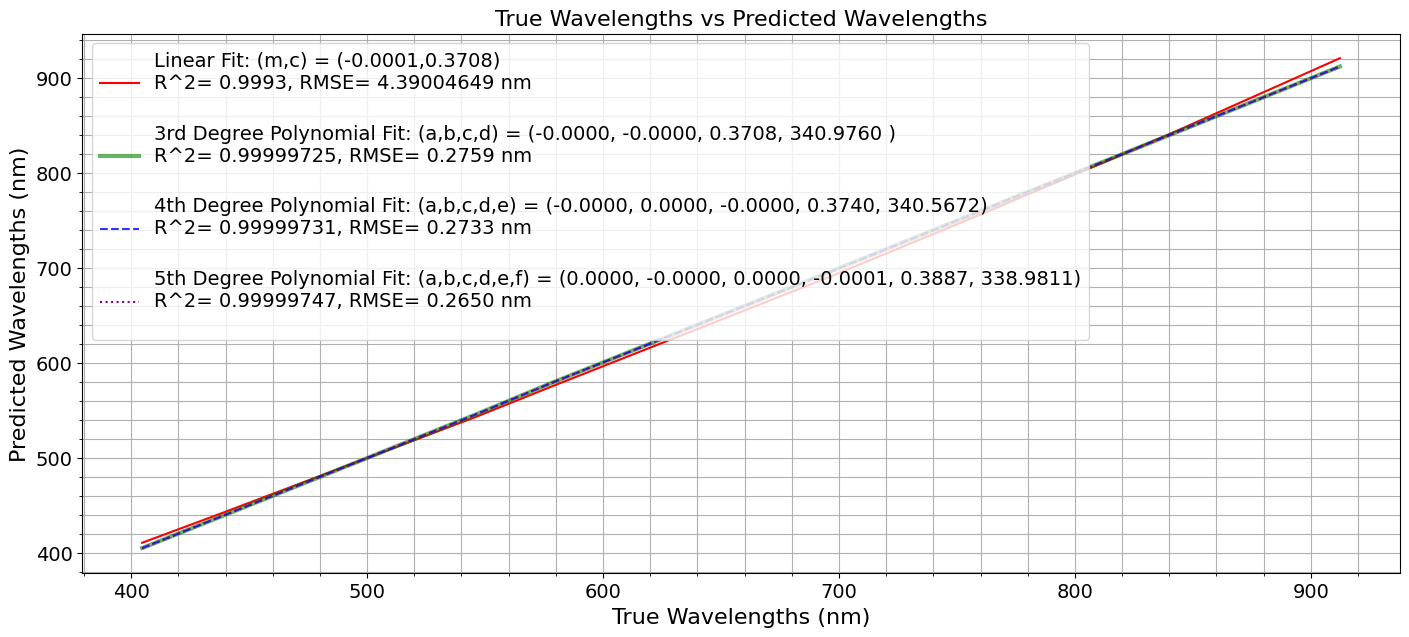

In [19]:
# Plot the true wavelengths vs the predicted wavelengths

fig = plt.figure(figsize=(17, 7))
plt.plot(table['True_wavelength'], table['linear_predicted_wavelength'], label=f'Linear Fit: (m,c) = ({m:.4f},{c:.4f}) \nR^2= {R2_linear:.4f}, RMSE= {rmse_linear:.8f} nm\n', color='red')
plt.plot(table['True_wavelength'], table['poly_predicted_wavelength'], label= f'3rd Degree Polynomial Fit: (a,b,c,d) = ({a:.4f}, {b:.4f}, {c:.4f}, {d:.4f} )\nR^2= {R2_poly:.8f}, RMSE= {rmse_poly:.4f} nm\n',color='green', alpha=0.6, linewidth=3)  
plt.plot(table['True_wavelength'], table['poly4_predicted_wavelength'], label= f'4th Degree Polynomial Fit: (a,b,c,d,e) = ({e:.4f}, {f:.4f}, {g:.4f}, {h:.4f}, {i:.4f})\nR^2= {R2_poly4:.8f}, RMSE= {rmse_poly4:.4f} nm\n',color='blue', linestyle='dashed', alpha=0.8)  
plt.plot(table['True_wavelength'], table['poly5_predicted_wavelength'], label= f'5th Degree Polynomial Fit: (a,b,c,d,e,f) = ({j:.4f}, {k:.4f}, {l:.4f}, {m:.4f}, {n:.4f}, {o:.4f})\nR^2= {R2_poly5:.8f}, RMSE= {rmse_poly5:.4f} nm\n',color='purple', linestyle='dotted', alpha=1)
plt.xlabel('True Wavelengths (nm)')
plt.ylabel('Predicted Wavelengths (nm)')
plt.grid(which='both')
plt.minorticks_on()
plt.title('True Wavelengths vs Predicted Wavelengths')
plt.legend(loc ='upper left')
plt.show()

**14. Plotting the Predicted wavelength vs Factory calibrated data for all the pixels to see how close our calibration is to the factory one**

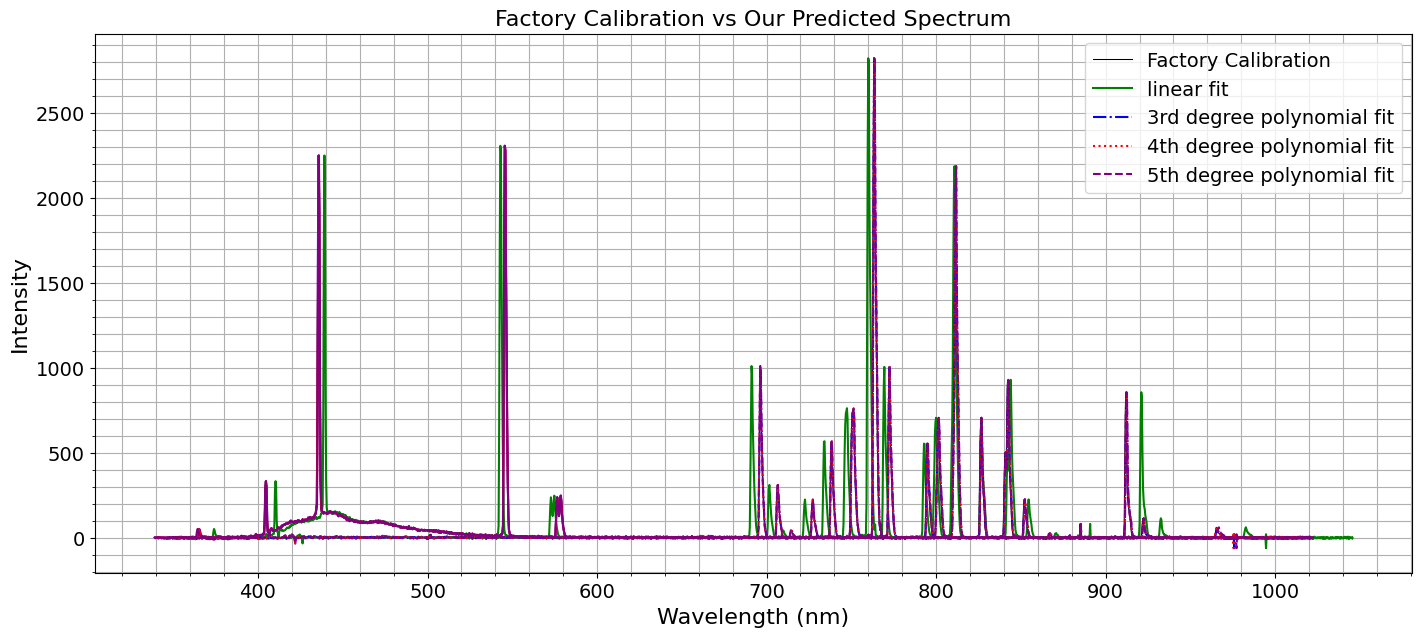

In [20]:
## plot of factory caliberated spectrum vs predicted spectrum

fig = plt.figure(figsize=(17, 7))
## factory caliberated spectrum
plt.plot(Ar_spectrum_copy[0], Ar_spectrum_copy[1], label='Factory Calibration', linewidth=0.75, color='black')
plt.plot(Hg_spectrum_copy[0], Hg_spectrum_copy[1], linewidth=0.75, color='black')

## linear fitted spectrum
plt.plot(Ar_spectrum['Pixels']*slope + intercept, Ar_spectrum['Intensity'], label='linear fit', color='green')
plt.plot(Hg_spectrum['Pixels']*slope + intercept, Hg_spectrum['Intensity'], color='green')

## 3rd degree polynomial fitted spectrum
plt.plot(Ar_spectrum['Pixels']**3*a + Ar_spectrum['Pixels']**2*b + Ar_spectrum['Pixels']*c + d, Ar_spectrum['Intensity'], label='3rd degree polynomial fit', color='blue', linestyle = '-.')
plt.plot(Hg_spectrum['Pixels']**3*a + Hg_spectrum['Pixels']**2*b + Hg_spectrum['Pixels']*c + d, Hg_spectrum['Intensity'], color='blue')

## 4th degree polynomial fitted spectrum
plt.plot(Ar_spectrum['Pixels']**4*e + Ar_spectrum['Pixels']**3*f + Ar_spectrum['Pixels']**2*g + Ar_spectrum['Pixels']*h + i, Ar_spectrum['Intensity'], label='4th degree polynomial fit', color='red',linestyle= 'dotted' )
plt.plot(Hg_spectrum['Pixels']**4*e + Hg_spectrum['Pixels']**3*f + Hg_spectrum['Pixels']**2*g + Hg_spectrum['Pixels']*h + i, Hg_spectrum['Intensity'], color='red')

## 5th degree polynomial fitted spectrum
plt.plot(Ar_spectrum['Pixels']**5*j + Ar_spectrum['Pixels']**4*k + Ar_spectrum['Pixels']**3*l + Ar_spectrum['Pixels']**2*m + Ar_spectrum['Pixels']*n + o, Ar_spectrum['Intensity'], label='5th degree polynomial fit', color='purple',linestyle ='dashed')
plt.plot(Hg_spectrum['Pixels']**5*j + Hg_spectrum['Pixels']**4*k + Hg_spectrum['Pixels']**3*l + Hg_spectrum['Pixels']**2*m + Hg_spectrum['Pixels']*n + o, Hg_spectrum['Intensity'], color='purple')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.grid(which='both')  
plt.title('Factory Calibration vs Our Predicted Spectrum')
plt.minorticks_on()
plt.legend()
plt.show()

**15. Zoomed In View for details viewing**

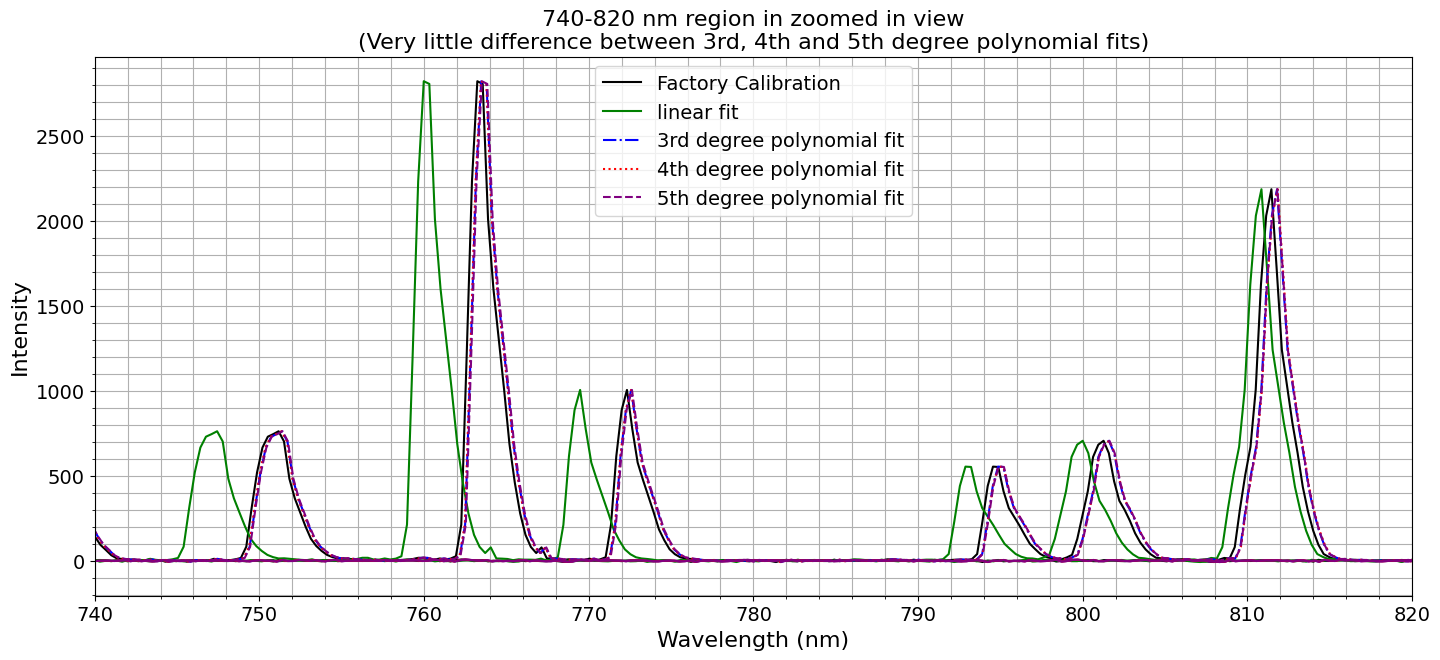

In [21]:
## Plotting 700-900 nm region in zoomed in view

fig = plt.figure(figsize=(17, 7))

## factory caliberated spectrum
plt.plot(Ar_spectrum_copy[0], Ar_spectrum_copy[1], label='Factory Calibration', color='black')
plt.plot(Hg_spectrum_copy[0], Hg_spectrum_copy[1], color='black')

## linear fitted spectrum
plt.plot(Ar_spectrum['Pixels']*slope + intercept, Ar_spectrum['Intensity'], label='linear fit', color='green')
plt.plot(Hg_spectrum['Pixels']*slope + intercept, Hg_spectrum['Intensity'], color='green')

## 3rd degree polynomial fitted spectrum
plt.plot(Ar_spectrum['Pixels']**3*a + Ar_spectrum['Pixels']**2*b + Ar_spectrum['Pixels']*c + d, Ar_spectrum['Intensity'], label='3rd degree polynomial fit', color='blue', linestyle = '-.')
plt.plot(Hg_spectrum['Pixels']**3*a + Hg_spectrum['Pixels']**2*b + Hg_spectrum['Pixels']*c + d, Hg_spectrum['Intensity'], color='blue')

## 4th degree polynomial fitted spectrum
plt.plot(Ar_spectrum['Pixels']**4*e + Ar_spectrum['Pixels']**3*f + Ar_spectrum['Pixels']**2*g + Ar_spectrum['Pixels']*h + i, Ar_spectrum['Intensity'], label='4th degree polynomial fit', color='red',linestyle= 'dotted' )
plt.plot(Hg_spectrum['Pixels']**4*e + Hg_spectrum['Pixels']**3*f + Hg_spectrum['Pixels']**2*g + Hg_spectrum['Pixels']*h + i, Hg_spectrum['Intensity'], color='red')

## 5th degree polynomial fitted spectrum
plt.plot(Ar_spectrum['Pixels']**5*j + Ar_spectrum['Pixels']**4*k + Ar_spectrum['Pixels']**3*l + Ar_spectrum['Pixels']**2*m + Ar_spectrum['Pixels']*n + o, Ar_spectrum['Intensity'], label='5th degree polynomial fit', color='purple',linestyle ='dashed')
plt.plot(Hg_spectrum['Pixels']**5*j + Hg_spectrum['Pixels']**4*k + Hg_spectrum['Pixels']**3*l + Hg_spectrum['Pixels']**2*m + Hg_spectrum['Pixels']*n + o, Hg_spectrum['Intensity'], color='purple')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.xlim(740,820)
plt.title('740-820 nm region in zoomed in view\n(Very little difference between 3rd, 4th and 5th degree polynomial fits)')
plt.show()